In [1]:
#project: p13
#submitter: bodla
#partner: kksun

In [2]:
import pandas as pd, matplotlib as mpl
import numpy as np
import os, requests, bs4, sqlite3, json

from pandas import Series, DataFrame
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

In [3]:
#lab-12 Functions

def download(filename, url):
    # We do not download again if the file already exists
    if os.path.exists(filename):
        return (str(filename) + " already exists!")

    # TODO: Write the code to download the file from URL
    # and save it in `filename`
    
    res = requests.get(url)
    res.raise_for_status()
    
    with open(filename, "w") as file:
        file.write(res.text)
    
    return (str(filename) + " created!")

In [4]:
#set up
path = 'countries.json'
download(path, "https://raw.githubusercontent.com/msyamkumar/cs220-f20-projects/master/p13/countries.json")
countries = pd.read_json('countries.json')

conn = sqlite3.connect('countries.db')
countries.to_sql("countries", conn, if_exists="replace", index=False)

In [5]:
#q1

def qry(q = "SELECT * FROM countries", sql = conn):
    return pd.read_sql(q, sql)

q = """
SELECT region, COUNT(region) as `number of countries`
FROM countries
GROUP BY region
ORDER BY `number of countries` DESC, region
"""
count_region = qry(q)
count_region

,region,number of countries
0,SUB-SAHARAN AFRICA,42
1,LATIN AMER. & CARIB,33
2,WESTERN EUROPE,22
3,ASIA (EX. NEAR EAST),21
4,NEAR EAST,13
5,C.W. OF IND. STATES,12
6,OCEANIA,12
7,EASTERN EUROPE,8
8,NORTHERN AFRICA,5
9,BALTICS,3


In [6]:
count_region = count_region.set_index("region")
None

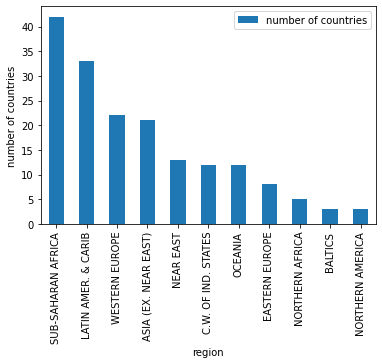

In [7]:
#q2
region_ax = count_region.plot.bar()
region_ax.set_ylabel("number of countries")
None

In [8]:
#q3
q = """
SELECT region, SUM(area) as `total area`
FROM countries
GROUP BY region
ORDER BY `total area` DESC, region
"""
area_region = qry(q)
area_region

,region,total area
0,ASIA (EX. NEAR EAST),22177295
1,C.W. OF IND. STATES,22100843
2,LATIN AMER. & CARIB,20426877
3,NORTHERN AMERICA,19616143
4,SUB-SAHARAN AFRICA,19446660
5,OCEANIA,8488612
6,NORTHERN AFRICA,5752890
7,NEAR EAST,4340116
8,WESTERN EUROPE,3707838
9,EASTERN EUROPE,938554


In [9]:
area_region = area_region.set_index("region")

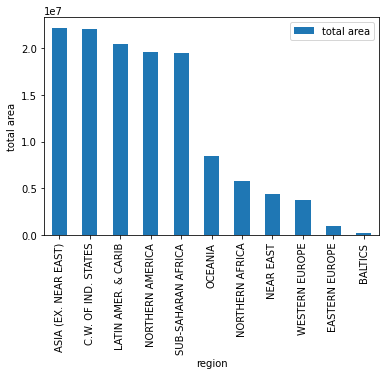

In [10]:
#q4
area_ax = area_region.plot.bar()
area_ax.set_ylabel("total area")
None

In [11]:
#q5
q = """
SELECT country, area
FROM countries
WHERE region == "NEAR EAST"
ORDER BY area DESC
"""

near_east_area = qry(q)
near_east_area

,country,area
0,Saudi Arabia,1960582
1,Turkey,780580
2,Yemen,527970
3,Iraq,437072
4,Oman,212460
5,Syria,185180
6,Jordan,92300
7,United Arab Emirates,82880
8,Israel,20770
9,Kuwait,17820


In [12]:
#q6

q = """
SELECT country, (population*`gdp-per-capita`) as `Real GDP(billion)`
FROM countries
ORDER BY `Real GDP(Billion)` DESC
"""

gdp = qry(q)
gdp["Real GDP(billion)"] /= 1000000000

gdp_top = gdp[:12]
gdp_top

,country,Real GDP(billion)
0,United States,11281.191327
1,China,6569.868565
2,Japan,3594.473830
3,India,3176.520785
4,Germany,2274.855452
5,France,1680.181354
6,United Kingdom,1678.873538
7,Italy,1552.164690
8,Brazil,1429.394525
9,Russia,1271.752506


In [13]:
gdp_top = gdp_top.set_index("country")

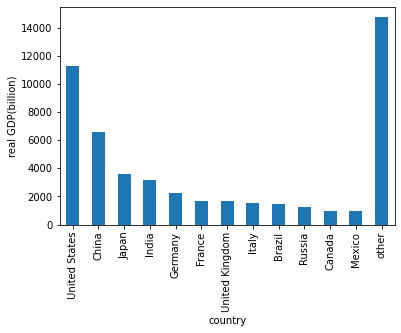

In [14]:
#q7

gdp_top_S = Series(gdp_top["Real GDP(billion)"])
gdp_top_S["other"] = gdp[12:].sum()["Real GDP(billion)"]

gdp_ax = gdp_top_S.plot.bar()
gdp_ax.set_ylabel("real GDP(billion)")
None

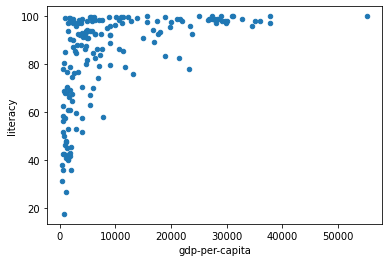

In [15]:
#q8

def plot_scatter(x_axis = "gdp-per-capita", y_axis = "literacy", f = None ):
    cols = qry()[[x_axis,y_axis]]
    
    # apply a change to a column
    if f:
        cols[y_axis] = cols[y_axis].apply(f)
    
    #return the data set, in case if we need further manipulating of data
    ax = cols.plot.scatter(x = x_axis, y = y_axis)
    None
    return (cols, ax)

plot_scatter(f = lambda str_ : float(str_.replace(",",".")))[1]
None

0.5154347345101354

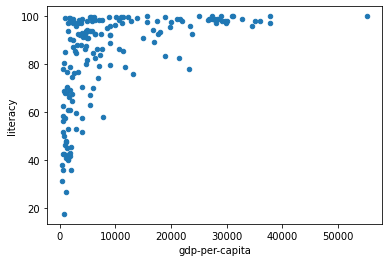

In [16]:
#q9
plot_scatter(f = lambda str_ : float(str_.replace(",",".")))[0].corr().iloc[0,1]

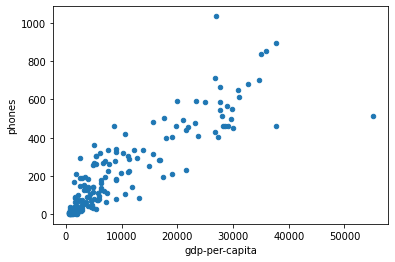

In [17]:
#q10
phones = plot_scatter(y_axis = "phones", f = lambda str_: float(str_.replace(",", ".")))
None

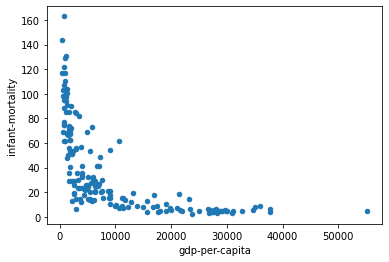

In [18]:
#q11
plot_scatter(y_axis = "infant-mortality")[1]
None

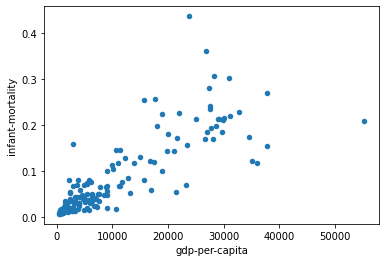

In [19]:
#q12
plot_scatter(y_axis = "infant-mortality", f = lambda rate : 1/rate)
None

In [20]:
#q13

phones_d = phones[0]
phones_d['1'] = 1

#data frames for the fit
inputs  = phones_d[["gdp-per-capita","1"]]
outputs = phones_d["phones"]

#least-square coeficients: (slope, intercepts)
lstsq_coef = np.linalg.lstsq(inputs, outputs, rcond=None)[0]
slope, intercept = lstsq_coef

slope, intercept

(0.01808887883603978, 37.95908987837674)

In [21]:
#q14
slope*30000+intercept

580.6254549595701

<AxesSubplot:xlabel='gdp-per-capita', ylabel='phones'>

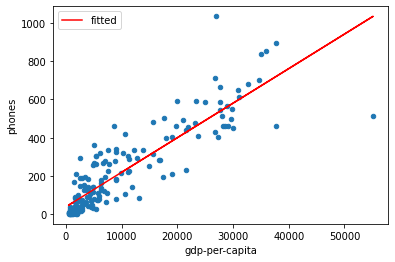

In [22]:
#q15

#fit (slope*x + intercept) regression line into the dataframe
phones_d['fitted'] = phones_d["gdp-per-capita"]*slope + intercept

ax = plot_scatter(y_axis = "phones", f = lambda str_: float(str_.replace(",", ".")))[1]
phones_d.plot.line(ax = ax, x="gdp-per-capita", y = "fitted", c = "red")

In [23]:
#q16

q = """
SELECT country, `birth-rate`, `death-rate`
FROM countries
ORDER BY `birth-rate` - `death-rate` ASC
LIMIT 15
"""

bd_gap = qry(q)
bd_gap

,country,birth-rate,death-rate
0,Botswana,23.08,29.50
1,Ukraine,8.82,14.39
2,Russia,9.95,14.65
3,Bulgaria,9.65,14.27
4,Latvia,9.24,13.66
5,Lesotho,24.75,28.71
6,South Africa,18.20,22.00
7,Monaco,9.19,12.91
8,Hungary,9.72,13.11
9,Estonia,10.04,13.25


In [24]:
bd_gap = bd_gap.set_index("country")

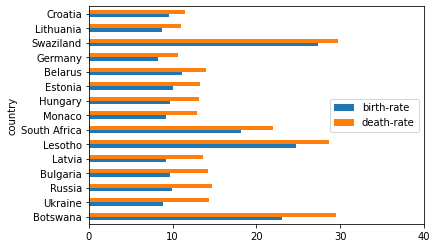

In [25]:
#q17
ax = bd_gap.plot.barh()
ax.set_xticks(range(0,50, 10))
None

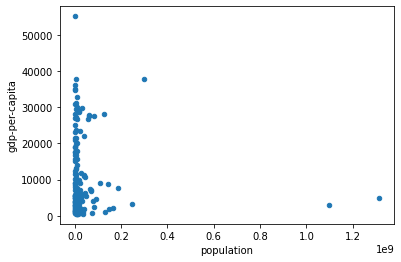

In [26]:
#q18
q = """
SELECT `gdp-per-capita`, population
FROM countries
"""
pop_gdp = qry(q)
pop_gdp.plot.scatter(x = "population", y = "gdp-per-capita")
None

In [27]:
#q19

q = """
SELECT country, population, `gdp-per-capita`
FROM countries
WHERE `gdp-per-capita` >= 55000 OR population > 290000000
ORDER BY `gdp-per-capita` ASC
"""
qry(q)

,country,population,gdp-per-capita
0,India,1095351995,2900
1,China,1313973713,5000
2,United States,298444215,37800
3,Luxembourg,474413,55100


In [28]:

q = """
SELECT country, population, `gdp-per-capita`
FROM countries
WHERE population > 1000000000 OR `gdp-per-capita` >= 37000 
ORDER BY `gdp-per-capita` ASC
"""
print(qry(q))

q = """
SELECT country, population, `gdp-per-capita`
FROM countries
WHERE population >= 298444215 OR `gdp-per-capita` >= 55000 
ORDER BY `gdp-per-capita` ASC
"""
qry(q)



         country  population  gdp-per-capita
0          India  1095351995            2900
1          China  1313973713            5000
2  United States   298444215           37800
3         Norway     4610820           37800
4     Luxembourg      474413           55100


,country,population,gdp-per-capita
0,India,1095351995,2900
1,China,1313973713,5000
2,United States,298444215,37800
3,Luxembourg,474413,55100


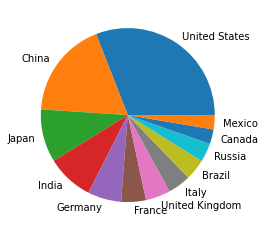

In [29]:
#q20

labels = list(gdp_top.index)
slices = list(gdp_top["Real GDP(billion)"])

fig, ax = plt.subplots()

ax.pie(slices, labels = labels)
None
# None

In [30]:
conn.close()